In [1]:
%matplotlib inline


============================================================
Encoding models for visual stimuli from Miyawaki et al. 2008
============================================================

This example partly reproduces the encoding model presented in
    `Visual image reconstruction from human brain activity
    using a combination of multiscale local image decoders
    <http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6>`_,
    Miyawaki, Y., Uchida, H., Yamashita, O., Sato, M. A.,
    Morito, Y., Tanabe, H. C., ... & Kamitani, Y. (2008).
    Neuron, 60(5), 915-929.

Encoding models try to predict neuronal activity using information from
presented stimuli, like an image or sound. Where decoding goes from
brain data to real-world stimulus, encoding goes the other direction.

We demonstrate how to build such an **encoding model** in nilearn, predicting
**fMRI data** from **visual stimuli**, using the dataset from
`Miyawaki et al., 2008
<http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6>`_.

Participants were shown images, which consisted of random 10x10 binary
(either black or white) pixels, and the corresponding fMRI activity was
recorded. We will try to predict the activity in each voxel
from the binary pixel-values of the presented images. Then we extract the
receptive fields for a set of voxels to see which pixel location a voxel
is most sensitive to.

See also :doc:`plot_miyawaki_reconstruction` for a decoding
approach for the same dataset.



Loading the data
----------------
Now we can load the data set:



In [2]:
from nilearn.datasets import fetch_miyawaki2008

dataset = fetch_miyawaki2008()

/home/bertrand/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Downloaded 161069109 of 161069109 bytes (100.0%,    0.0s remaining) ...done. (161 seconds, 2 min)
Extracting data from /home/bertrand/mygit/nilearn/nilearn_data/miyawaki2008/4356183cd5ae215342603c6edeb89f54/miyawaki2008.tgz..... done.


We only use the training data of this study,
where random binary images were shown.



In [3]:
# training data starts after the first 12 files
fmri_random_runs_filenames = dataset.func[12:]
stimuli_random_runs_filenames = dataset.label[12:]

We can use :func:`nilearn.input_data.MultiNiftiMasker` to load the fMRI
data, clean and mask it.



In [4]:
import numpy as np
from nilearn.input_data import MultiNiftiMasker

masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,
                          standardize=True)
masker.fit()
fmri_data = masker.transform(fmri_random_runs_filenames)

# shape of the binary (i.e. black and wihte values) image in pixels
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli = []
for stimulus_run in stimuli_random_runs_filenames:
    stimuli.append(np.reshape(np.loadtxt(stimulus_run,
                              dtype=np.int, delimiter=','),
                              (-1,) + stimulus_shape, order='F'))

Let's take a look at some of these binary images:



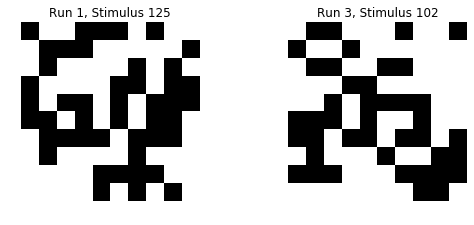

In [5]:
import pylab as plt
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(stimuli[0][124], interpolation='nearest', cmap='gray')
plt.axis('off')
plt.title('Run {}, Stimulus {}'.format(1, 125))
plt.subplot(1, 2, 2)
plt.imshow(stimuli[2][101], interpolation='nearest', cmap='gray')
plt.axis('off')
plt.title('Run {}, Stimulus {}'.format(3, 102))
plt.subplots_adjust(wspace=0.5)

We now stack the fmri and stimulus data and remove an offset in the
beginning/end.



In [6]:
fmri_data = np.vstack([fmri_run[2:] for fmri_run in fmri_data])
stimuli = np.vstack([stimuli_run[:-2] for stimuli_run in stimuli]).astype(float)

fmri_data is a matrix of *samples* x *voxels*



In [7]:
print(fmri_data.shape)

(2860, 5438)


We flatten the last two dimensions of stimuli
so it is a matrix of *samples* x *pixels*.



In [8]:
# Flatten the stimuli
stimuli = np.reshape(stimuli, (-1, stimulus_shape[0] * stimulus_shape[1]))

print(stimuli.shape)

(2860, 100)


Building the encoding models
----------------------------
We can now proceed to build a simple **voxel-wise encoding model** using
`Ridge regression <http://en.wikipedia.org/wiki/Tikhonov_regularization>`_.
For each voxel we fit an independent regression model,
using the pixel-values of the visual stimuli to predict the neuronal
activity in this voxel.



In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

Using 10-fold cross-validation, we partition the data into 10 'folds'.
We hold out each fold of the data for testing, then fit a ridge regression
to the remaining 9/10 of the data, using stimuli as predictors
and fmri_data as targets, and create predictions for the held-out 10th.



In [10]:
from sklearn.metrics import r2_score

estimator = Ridge(alpha=100.)
cv = KFold(n_splits=10)

scores = []
for train, test in cv.split(X=stimuli):
    # we train the Ridge estimator on the training set
    # and predict the fMRI activity for the test set
    predictions = Ridge(alpha=100.).fit(
    stimuli.reshape(-1, 100)[train], fmri_data[train]).predict(
        stimuli.reshape(-1, 100)[test])
    # we compute how much variance our encoding model explains in each voxel
    scores.append(r2_score(fmri_data[test], predictions,
                           multioutput='raw_values'))

Mapping the encoding scores on the brain
----------------------------------------
To plot the scores onto the brain, we create a Nifti1Image containing
the scores and then threshold it:



In [11]:
from nilearn.image import threshold_img
cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0

# bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6)

Plotting the statistical map on a background brain, we mark four voxels
which we will inspect more closely later on.



/home/bertrand/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


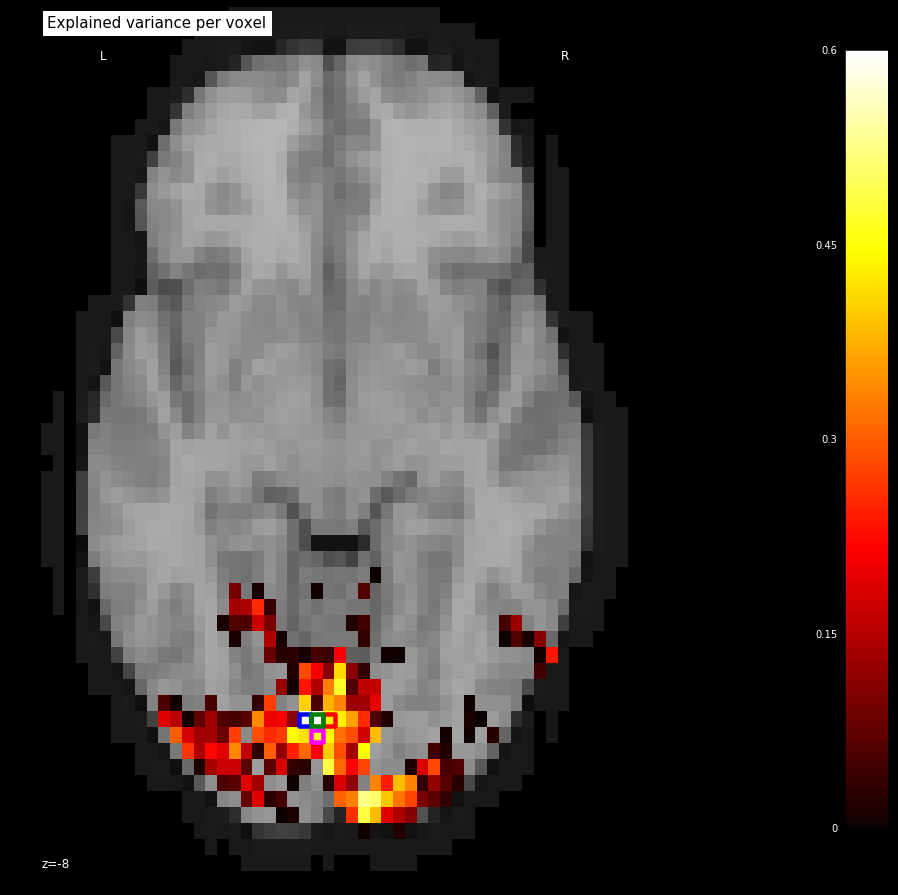

In [12]:
from nilearn.plotting import plot_stat_map
from nilearn.image import coord_transform

def index_to_xy_coord(x, y, z=10):
    '''Transforms data index to coordinates of the background + offset'''
    coords = coord_transform(x, y, z,
                             affine=thresholded_score_map_img.affine)
    return np.array(coords)[np.newaxis, :] + np.array([0, 1, 0])


xy_indices_of_special_voxels = [(30, 10), (32, 10), (31, 9), (31, 10)]

display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel')

# creating a marker for each voxel and adding it to the statistical map

for i, (x, y) in enumerate(xy_indices_of_special_voxels):
    display.add_markers(index_to_xy_coord(x, y), marker_color='none',
                        edgecolor=['b', 'r', 'magenta', 'g'][i],
                        marker_size=140, marker='s',
                        facecolor='none', lw=4.5)


# re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(12, 12)

Estimating receptive fields
---------------------------
Now we take a closer look at the receptive fields of the four marked voxels.
A voxel's `receptive field <http://en.wikipedia.org/wiki/Receptive_field>`_
is the region of a stimulus (like an image) where the presence of an object,
like a white instead of a black pixel, results in a change in activity
in the voxel. In our case the receptive field is just the vector of 100
regression  coefficients (one for each pixel) reshaped into the 10x10
form of the original images. Some voxels are receptive to only very few
pixels, so we use `Lasso regression
<http://en.wikipedia.org/wiki/Lasso_(statistics)>`_ to estimate a sparse
set of regression coefficients.



/home/bertrand/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/bertrand/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/bertrand/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/bertrand/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  w

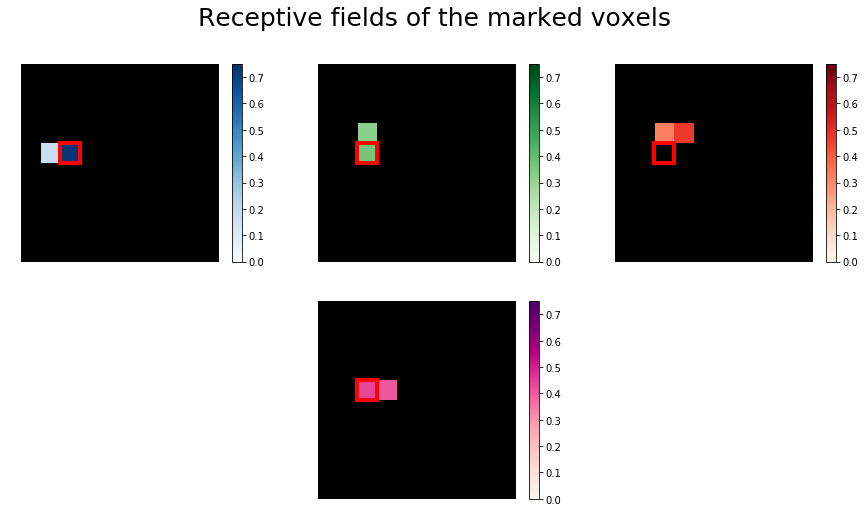

In [13]:
from sklearn.linear_model import LassoLarsCV

# automatically estimate the sparsity by cross-validation
lasso = LassoLarsCV(max_iter=10)

# Mark the same pixel in each receptive field
marked_pixel = (4, 2)

from matplotlib import gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(12, 8))
fig.suptitle('Receptive fields of the marked voxels', fontsize=25)

# GridSpec allows us to do subplots with more control of the spacing
gs1 = gridspec.GridSpec(2, 3)

# we fit the Lasso for each of the three voxels of the upper row
for i, index in enumerate([1780, 1951, 2131]):
    ax = plt.subplot(gs1[0, i])
    # we reshape the coefficients into the form of the original images
    rf = lasso.fit(stimuli, fmri_data[:, index]).coef_.reshape((10, 10))
    # add a black background
    ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
    ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                      cmap=['Blues', 'Greens', 'Reds'][i], vmin=0., vmax=0.75)
    # add the marked pixel
    ax.add_patch(Rectangle(
        (marked_pixel[1] - .5, marked_pixel[0] - .5), 1, 1,
        facecolor='none', edgecolor='r', lw=4))
    plt.axis('off')
    plt.colorbar(ax_im, ax=ax)

# and then for the voxel at the bottom

gs1.update(left=0., right=1., wspace=0.1)
ax = plt.subplot(gs1[1, 1])
# we reshape the coefficients into the form of the original images
rf = lasso.fit(stimuli, fmri_data[:, 1935]).coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='RdPu', vmin=0., vmax=0.75)

# add the marked pixel
ax.add_patch(Rectangle(
    (marked_pixel[1] - .5, marked_pixel[0] - .5), 1, 1,
    facecolor='none', edgecolor='r', lw=4))
plt.axis('off')
plt.colorbar(ax_im, ax=ax)

The receptive fields of the four voxels are not only close to each other,
the relative location of the pixel each voxel is most sensitive to
roughly maps to the relative location of the voxels to each other.
We can see a relationship between some voxel's receptive field and
its location in the brain.

